In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.mlab
import scipy.io.wavfile
import scipy
import scipy.fftpack
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('/home/husein/space/UrbanSound8K/metadata/UrbanSound8K.csv')
dataset.slice_file_name = 'audio/fold' + dataset.fold.astype(str) + '/' + dataset.slice_file_name
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
3996,audio/fold5/178260-7-1-5.wav,178260,7.837693,11.837693,1,5,7,jackhammer
5428,audio/fold5/204408-2-0-8.wav,204408,4.000000,8.000000,2,5,2,children_playing
1994,audio/fold2/147926-0-0-36.wav,147926,18.000000,22.000000,1,2,0,air_conditioner
4349,audio/fold1/180937-7-3-1.wav,180937,305.084561,309.084561,2,1,7,jackhammer
8559,audio/fold8/96159-4-0-0.wav,96159,0.751209,4.033599,1,8,4,drilling


In [3]:
unique_sound = np.unique(dataset.iloc[:, -1])
unique_sound

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [4]:
# define our global variables
learning_rate = 0.001
sound_dimension = [64, 512]
batch_size = 128
epoch = 20

In [5]:
def processAudio(audio_file):
    rate, data = scipy.io.wavfile.read(audio_file)
    try:
        if data.shape[1]:
            data = np.mean(data, axis = 1)
    except:
        pass
    audio = scipy.fftpack.fft(data)
    audio = scipy.fftpack.fftshift(audio)
    log_amp_spectrum = np.log10(np.abs(audio))
    audio = matplotlib.mlab.specgram(log_amp_spectrum)[0]
    return scipy.misc.imresize(audio, sound_dimension).flatten()

In [6]:
class Model:
    def __init__(self, size_output):
        self.X = tf.placeholder(tf.float32, (None, sound_dimension[0] * sound_dimension[1]))
        self.Y = tf.placeholder(tf.float32, (None, size_output))
        
        w1 = tf.Variable(tf.random_normal([sound_dimension[0] * sound_dimension[1], 784], stddev = np.sqrt(1/784.0)))
        b1 = tf.Variable(tf.random_normal([784], stddev = 0))
        
        w2 = tf.Variable(tf.random_normal([784, 256], stddev = np.sqrt(1/256.0)))
        b2 = tf.Variable(tf.random_normal([256], stddev = 0))
        
        w3 = tf.Variable(tf.random_normal([256, 100], stddev = np.sqrt(1/100.0)))
        b3 = tf.Variable(tf.random_normal([100], stddev = 0))
        
        w4 = tf.Variable(tf.random_normal([100, size_output], stddev = np.sqrt(1/(size_output * 1.0))))
        b4 = tf.Variable(tf.random_normal([size_output], stddev = 0))
        
        hidden1 = tf.nn.relu(tf.matmul(self.X, w1) + b1)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2)
        hidden3 = tf.nn.relu(tf.matmul(hidden2, w3) + b3)
        self.logits = tf.matmul(hidden3, w4) + b4
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [7]:
no_classes = np.unique(dataset['classID']).shape[0]
sess = tf.InteractiveSession()
model = Model(no_classes)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

train_dataset = dataset.iloc[:int(dataset.shape[0] * 0.80), :]
test_dataset = dataset.iloc[int(dataset.shape[0] * 0.80):, :]

In [8]:
ACCURACY, LOST = [], []
for i in range(epoch):
    last = time.time()
    total_acc, total_loss = 0, 0
    for k in range(0, (train_dataset.shape[0] // batch_size) * batch_size, batch_size):
        batch_x, batch_y = [], []
        for n in range(batch_size):
            try:
                batch_x.append(processAudio(train_dataset.slice_file_name.iloc[k + n]))
                onehot = np.zeros((no_classes))
                onehot[train_dataset.classID.iloc[k + n]] = 1.0
                batch_y.append(onehot)
            except Exception as e:
                continue
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_acc += sess.run(model.accuracy, feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_loss += loss
    total_loss /= (train_dataset.shape[0] // batch_size)
    total_acc /= (train_dataset.shape[0] // batch_size)
    ACCURACY.append(total_acc)
    LOST.append(total_loss)
    print('epoch: ', i + 1, 'avg loss: ', total_loss, 'avg acc: ', total_acc, 'avg time: ', (time.time() - last) / (train_dataset.shape[0] // batch_size))

('epoch: ', 1, 'avg loss: ', 129.18411664609556, 'avg acc: ', 0.12572850373194175, 'avg time: ', 6.581447632224472)
('epoch: ', 2, 'avg loss: ', 18.756489789044416, 'avg acc: ', 0.1803454140684119, 'avg time: ', 6.577268649030615)
('epoch: ', 3, 'avg loss: ', 21.322976765809237, 'avg acc: ', 0.17385233041864853, 'avg time: ', 6.5761182617258145)
('epoch: ', 4, 'avg loss: ', 8.6499834413881658, 'avg acc: ', 0.25918739178666361, 'avg time: ', 6.686059183544582)
('epoch: ', 5, 'avg loss: ', 6.028217858738369, 'avg acc: ', 0.27261674624902232, 'avg time: ', 6.57213188983776)
('epoch: ', 6, 'avg loss: ', 8.1752345032162133, 'avg acc: ', 0.24616177104137563, 'avg time: ', 6.566393463699906)
('epoch: ', 7, 'avg loss: ', 9.3683239265724456, 'avg acc: ', 0.23329312437110478, 'avg time: ', 6.564795370455141)
('epoch: ', 8, 'avg loss: ', 6.5071152448654175, 'avg acc: ', 0.25272509552262445, 'avg time: ', 6.566695129429853)
('epoch: ', 9, 'avg loss: ', 3.1484040684170194, 'avg acc: ', 0.3092138405

In [9]:
batch_x, batch_y, labels = [], [], []
for n in range(test_dataset.shape[0]):
    try:
        batch_x.append(processAudio(test_dataset.slice_file_name.iloc[n]))
        onehot = np.zeros((no_classes))
        onehot[test_dataset.classID.iloc[n]] = 1.0
        batch_y.append(onehot)
        labels.append(test_dataset.classID.iloc[n])
    except Exception as e:
        continue
batch_x = np.array(batch_x)
batch_y = np.array(batch_y)
acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : batch_x, model.Y : batch_y})
print 'testing accuracy: ' + str(acc)
print(metrics.classification_report(labels, logits, target_names = np.unique(unique_sound)))

testing accuracy: 0.293972
                  precision    recall  f1-score   support

 air_conditioner       0.31      0.04      0.07       128
        car_horn       0.00      0.00      0.00        58
children_playing       0.24      0.47      0.32       131
        dog_bark       1.00      0.03      0.06       152
        drilling       0.72      0.25      0.37       170
   engine_idling       1.00      0.06      0.11       121
        gun_shot       0.00      0.00      0.00        49
      jackhammer       0.20      0.99      0.33       139
           siren       0.54      0.67      0.60       142
    street_music       1.00      0.02      0.03       121

     avg / total       0.57      0.29      0.22      1211



/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


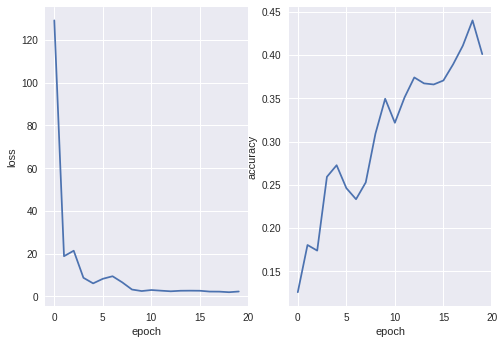

In [10]:
EPOCH = np.arange(len(LOST))
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()